### Reproduce the IMG/VR subset

In [1]:
import re
import pandas as pd

# Helper functions
# Function to extract host taxonomy domain
def extract_host_taxonomy_domain(host_taxonomy):
    # Split the string by ';'
    parts = host_taxonomy.split(';')
    # Take the first part and remove the prefix (e.g., d__)
    domain = parts[0].split('__')[-1] if parts else ''
    if not re.search('[a-zA-Z]', domain):
        domain = "Unknown"
    return domain

def extract_virus_realm(virus_taxonomy):
    parts = virus_taxonomy.split(';')
    for part in parts:
        if part.startswith('r__'):
            return part.split('__')[-1]
    return ''

def by_kingdom(dframe):
    return dframe['Host taxonomy prediction'].apply(extract_host_taxonomy_domain).value_counts()

def by_realm(dframe):
    return dframe['Taxonomic classification'].apply(extract_virus_realm).value_counts()
    

In [2]:
img_vr_file = "IMG_VR/IMG_VR_2022-09-20_6.1/IMGVR_all_Sequence_information-high_confidence.tsv"
v0 = pd.read_csv(img_vr_file, header=0, sep='\t', low_memory=False)

In [3]:
v0.shape

(5576197, 19)

### Step 0. Representative viral OTU
- Keep only one representative viral genome per viral operational taxonomic unit (vOTU)

In [4]:
v0 = v0.drop_duplicates(subset='vOTU')
v0['vOTU'].nunique()

2917521

### Step 1. Remove potential eukaryotic viruses
- Remove potential eukaryotic viruses by keeping only sequences whose assigned taxonomic classification was found within a prokaryotic host at least twice.

In [5]:
# Extract host domain
v0.loc[:, 'Host_domain'] = v0.loc[:, 'Host taxonomy prediction'].apply(extract_host_taxonomy_domain)

# Calculate the total count of each unique Taxonomic classification value by Host_domain
host_domain_counts = v0.groupby(['Taxonomic classification', 'Host_domain']).size().unstack(fill_value=0)
host_domain_counts['Prokaryotic'] = host_domain_counts['Bacteria'] + host_domain_counts['Archaea']
to_remove = host_domain_counts[(host_domain_counts['Prokaryotic'] < 2)].index.tolist()

v1 = v0[~v0['Taxonomic classification'].isin(to_remove)]

### Step 2. Remove known pathogenic genomes
- Exclude all viruses assigned to certain families or orders based on safety precaution.

In [6]:
excluded_families = [
    "f__Adenoviridae", "f__Caliciviridae", "f__Coronaviridae", "f__Filoviridae", "f__Flaviviridae", 
    "f__Hantaviridae", "f__Hepadnaviridae", "f__Herpesviridae", "f__Orthomyxoviridae", 
    "f__Papillomaviridae", "f__Paramyxoviridae", "f__Picornaviridae", "f__Poxviridae", 
    "f__Reoviridae", "f__Retroviridae", "f__Rhabdoviridae", "f__Circoviridae", 
    "f__Geminiviridae", "f__Picobirnaviridae"
]

excluded_orders = [
    "o__Amarillovirales", "o__Durnavirales", "o__Geplafuvirales", "o__Herpesvirales", 
    "o__Lefavirales", "o__Ortervirales", "o__Orthopolintovirales", "o__Piccovirales", 
    "o__Picornavirales", "o__Priklausovirales", "o__Cirlivirales", "o__Mulpavirales"
]

excluded_list = excluded_families + excluded_orders

def exclude_classifications(taxa_class):
    parts = taxa_class.split(';')
    for item in excluded_list:
        if item in parts:
            return False
    return True

v2 = v1[v1['Taxonomic classification'].apply(exclude_classifications)]

### Step 3. Remove genomes with poor taxonomic specificity
- Remove viruses with poor taxonomic specificity, including those with no assigned realm at all, and those only assigned up to the level of r:Riboviria, r:Monodnaviria, k:Heunggongvirae, k:Bamfordvirae, p:Preplasmiviricota, p:Cressdnaviricota, p:Pisuviricota, or c:Tectiliviricetes

In [7]:
# Keep viruses if specified realm
v3a = v2[v2['Taxonomic classification'].str.startswith('r__')]

In [8]:
def filter_by_taxa(df, excluded_taxa):
    pattern = '|'.join(excluded_taxa)
    df_filtered = df[~df['Taxonomic classification'].str.contains(pattern, regex=True)]
    return df_filtered

excluded_taxa = [
    "r__Riboviria;;", "r__Monodnaviria;;", "k__Heunggongvirae;;", "k__Bamfordvirae;;", 
    "p__Preplasmiviricota;;", "p__Cressdnaviricota;;", "p__Pisuviricota;;", "c__Tectiliviricetes;;"
]

v3b = filter_by_taxa(v3a, excluded_taxa)

In [9]:
v3b.shape

(2646663, 20)

In [10]:
by_kingdom(v3b)

Host taxonomy prediction
Unknown     2368638
Bacteria     276324
Archaea        1701
Name: count, dtype: int64

In [11]:
by_realm(v3b)

Taxonomic classification
Duplodnaviria     2628319
Monodnaviria        17782
Varidnaviria          395
Adnaviria             124
Bicaudaviridae         35
Fuselloviridae          8
Name: count, dtype: int64

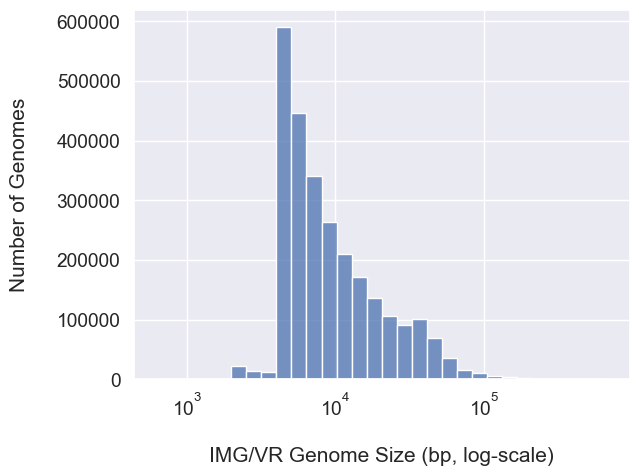

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.25)
sns.histplot(data=v3b, x='Length', log_scale=True, bins=30)
plt.xlabel('\nIMG/VR Genome Size (bp, log-scale)')
plt.ylabel('Number of Genomes\n')
plt.savefig('img_vr_genome_size_log.png', dpi=800)
plt.show()

In [13]:
v3b.shape[0], round(v3b['Length'].sum() / 1e6), round(v3b['Length'].mean())

(2646663, 35562, 13437)